# 2. Solving model

## Pyomo

In [ ]:
!pip install pyomo
!apt-get install -y glpk-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


### Parameters ###

In [ ]:
import pandas as pd
from pyomo.environ import *

model_p= ConcreteModel(name="berth_scheduling")

# Sets
model_p.Ships = RangeSet(1, 8)
model_p.Berths = RangeSet(1, 4)


# loading excel sheets
c = pd.read_excel('Parameters.xlsx', sheet_name='Containers')
C = pd.read_excel('Parameters.xlsx', sheet_name='Capacity')
l = pd.read_excel('Parameters.xlsx', sheet_name='Length')
L = pd.read_excel('Parameters.xlsx', sheet_name='Max Length')
t = pd.read_excel('Parameters.xlsx', sheet_name='Unload Time')
p = pd.read_excel('Parameters.xlsx', sheet_name='Priority')
C_ec = pd.read_excel('Parameters.xlsx', sheet_name='Cost for Extra Capacity')
E = pd.read_excel('Parameters.xlsx', sheet_name='Max Extra Allowable Capacity')
A = pd.read_excel('Parameters.xlsx', sheet_name='Arrival Time')
epsilon = pd.read_excel('Parameters.xlsx', sheet_name='Lag')
anch = pd.read_excel('Parameters.xlsx', sheet_name='Anchorage')

# fixing tuple in Ship_Berth column
t['Ship_Berth'] = t['Ship_Berth'].apply(eval)
t['Ship_Berth'] = t['Ship_Berth'].apply(lambda x: (int(x[0]), int(x[1])))

# creating dictionaries from DataFrames
c = dict(zip(c['Ship'], c['Containers']))
C = dict(zip(C['Berth'], C['Capacity']))
l = dict(zip(l['Ship'], l['Length']))
L = dict(zip(L['Berth'], L['Max_Length']))
t_dict = dict(zip(t['Ship_Berth'], t['Unload_Time']))
p = dict(zip(p['Ship'], p['Priority']))
C_ec = dict(zip(C_ec['Berth'], C_ec['Cost for Extra Capacity']))
E = dict(zip(E['Berth'], E['Max Extra Allowable Capacity']))
A = dict(zip(A['Ship'], A['Arrival_Time']))
epsilon = dict(zip(epsilon['Berth'], epsilon['Lag']))
anch = dict(zip(anch['Berth'], anch['Anchorage']))


model_p.ShipBerths = Set(dimen=2, initialize=t_dict.keys())


# parameters
model_p.c = Param(model_p.Ships, initialize=c, mutable=True)
model_p.C = Param(model_p.Berths, initialize=C, mutable=True)
model_p.l = Param(model_p.Ships, initialize=l, mutable=True)
model_p.L = Param(model_p.Berths, initialize=L, mutable=True)
model_p.t = Param(model_p.ShipBerths, initialize=t_dict, mutable=True)
model_p.p = Param(model_p.Ships, initialize=p, mutable=True)
model_p.C_ec = Param(model_p.Berths, initialize=C_ec, mutable=True)
model_p.E = Param(model_p.Berths, initialize=E, mutable=True)
model_p.A = Param(model_p.Ships, initialize=A, mutable=True)
model_p.epsilon = Param(model_p.Berths, initialize=epsilon, mutable=True)
model_p.anch = Param(model_p.Berths, initialize=anch, mutable=True)

### Variables

In [ ]:

# if ship i assigned to berth j
model_p.x = Var(model_p.Ships, model_p.Berths, domain=Binary)

# if ship i is shipper than k
model_p.Y_index = Set(initialize=[(i, k) for i in model_p.Ships for k in model_p.Ships if i < k])
model_p.y = Var(model_p.Y_index, domain=Binary)

# waiting time of ship i
model_p.W = Var(model_p.Ships, domain=NonNegativeReals)

# used extra capacity
model_p.u = Var(model_p.Berths, domain=NonNegativeReals)

# if W[i] ≥ 10
model_p.delta1 = Var(model_p.Ships, domain=Binary)

# if W[i] ≥ 40
model_p.delta2 = Var(model_p.Ships, domain=Binary)

# if W[i] ≥ 10
model_p.d1 = Var(model_p.Ships, domain=NonNegativeReals)

# if W[i] ≥ 40
model_p.d2 = Var(model_p.Ships, domain=NonNegativeReals)




### Objective Function

In [ ]:
M = 100  # Big-M constant

In [ ]:
def objective_rule(model_p):
    # 1. C_unload: sum over ship-berth pairs
    unload_cost = sum(
        5 * model_p.t[i, j] * model_p.x[i, j]
        for (i, j) in model_p.ShipBerths
    )

    # 2. C_EC: sum over berths
    extra_capacity_cost = sum(
        model_p.C_ec[j] * model_p.u[j] for j in model_p.Berths
    )

    # 3. C_W: sum over ships
    waiting_cost = sum(
        25 * model_p.W[i]
        - 15 * model_p.d1[i] + 150 * model_p.delta1[i]
        - 5 * model_p.d2[i] + 200 * model_p.delta2[i]
        for i in model_p.Ships
    )

    return unload_cost + waiting_cost + extra_capacity_cost





model_p.objective = Objective(rule=objective_rule, sense=minimize)


### Constraints

In [ ]:
# each ship is assigned to exactly one berth
def assign_one_berth(model_p, i):
    return sum(model_p.x[i, j] for j in model_p.Berths if (i, j) in model_p.ShipBerths) == 1
model_p.one_berth_per_ship = Constraint(model_p.Ships, rule=assign_one_berth)


# number of ships assigned to berths
def max_two_ships_per_berth_1_and_2_and_4(model_p, j):
    if j in [1, 2, 4]:
        return sum(model_p.x[i, j] for i in model_p.Ships if (i, j) in model_p.ShipBerths) <= model_p.anch[j]
    else:
        return Constraint.Skip
model_p.max_ships_berth = Constraint(model_p.Berths, rule=max_two_ships_per_berth_1_and_2_and_4)


def exactly_three_ships_berth_3(model_p):
    return sum(model_p.x[i, 3] for i in model_p.Ships if (i, 3) in model_p.ShipBerths) == 3
model_p.exact_three_ships_berth3 = Constraint(rule=exactly_three_ships_berth_3)


# length constraint
def length_constraint(model_p, i, j):
    return model_p.l[i] * model_p.x[i, j] <= model_p.L[j]
model_p.length_constraint = Constraint(model_p.Ships, model_p.Berths, rule=length_constraint)


# berths capacity
def berth_capacity_constraint(model_p, j):
    return sum(model_p.c[i] * model_p.x[i, j] for i in model_p.Ships if (i, j) in model_p.ShipBerths) <= model_p.C[j] + model_p.u[j]
model_p.capacity_constraint = Constraint(model_p.Berths, rule=berth_capacity_constraint)


# each berth extra capacity
def each_berth_capacity_constraint(model_p, j):
    return model_p.u[j] <= model_p.E[j]
model_p.berth_capacity_constraint = Constraint(model_p.Berths, rule=each_berth_capacity_constraint)


# Constraint: p[k] - p[i] <= y[i,k]
def priority_1(model_p, i, k):
    return model_p.p[i] - model_p.p[k] <= model_p.y[i, k]
model_p.priority_con_1 = Constraint(model_p.Y_index, rule=priority_1)


# Constraint: p[k] - p[i] <= 1 - y[i,k]
def priority_2(model_p, i, k):
    return model_p.p[k] - model_p.p[i] <= 1 - model_p.y[i, k]
model_p.priority_con_2 = Constraint(model_p.Y_index, rule=priority_2)


# SEQUENCING 1
def sequencing_constraint_1(model_p, i, k, j):
    if i < k:
        return (
            model_p.W[k] + model_p.A[k] >=
            model_p.W[i] + model_p.A[i] + model_p.t[i, j] + model_p.epsilon[j]
            - M * (3 - model_p.y[i, k] - model_p.x[i, j] - model_p.x[k, j])
        )
    else:
        return Constraint.Skip
model_p.Sequencing1 = Constraint(model_p.Ships, model_p.Ships, model_p.Berths, rule=sequencing_constraint_1)


# SEQUENCING 2
def sequencing_constraint_2(model_p, i, k, j):
    if i < k:
        return (
            model_p.W[i] + model_p.A[i] >=
            model_p.W[k] + model_p.A[k] + model_p.t[k, j] + model_p.epsilon[j]
            - M * (model_p.y[i, k] + 2 - model_p.x[i, j] - model_p.x[k, j])
        )
    else:
        return Constraint.Skip
model_p.Sequencing2 = Constraint(model_p.Ships, model_p.Ships, model_p.Berths, rule=sequencing_constraint_2)


# W[i] <= 80 * [1 - p[i]]
def waiting_upper(model_p, i):
    return model_p.W[i] <= 80 * (1 - model_p.p[i])
model_p.waiting_upper_con = Constraint(model_p.Ships, rule=waiting_upper)


# Constraint: W[i] - 10 <= M delta1[i]
def delta1_conditional_lower(model_p, i):
    return model_p.W[i] - 10 <= M * model_p.delta1[i]
model_p.delta1_lower_con = Constraint(model_p.Ships, rule=delta1_conditional_lower)


# Constraint: W[i] - 40 <= M delta2[i]
def delta2_conditional_lower(model_p, i):
    return model_p.W[i] - 40 <= M * model_p.delta2[i]
model_p.delta2_lower_con = Constraint(model_p.Ships, rule=delta2_conditional_lower)


# Constraint: d1[i] <= W[i]
def d1_conditional_upper1(model_p, i):
    return model_p.d1[i] <= model_p.W[i]
model_p.d1_conditional_con1 = Constraint(model_p.Ships, rule=d1_conditional_upper1)


# Constraint: d2[i] <= W[i]
def d2_conditional_upper1(model_p, i):
    return model_p.d2[i] <= model_p.W[i]
model_p.d2_conditional_con1 = Constraint(model_p.Ships, rule=d2_conditional_upper1)


# Constraint: d1[i] <= M * delta1[i]
def d1_conditional_upper2(model_p, i):
    return model_p.d1[i] <= M * model_p.delta1[i]
model_p.d1_conditional_con2 = Constraint(model_p.Ships, rule=d1_conditional_upper2)


# Constraint: d2[i] <= M * delta2[i]
def d2_conditional_upper2(model_p, i):
    return model_p.d2[i] <= M * model_p.delta2[i]
model_p.d2_conditional_con2 = Constraint(model_p.Ships, rule=d2_conditional_upper2)


### Solving

In [ ]:
from pyomo.opt import SolverStatus, TerminationCondition
!apt-get install -y glpk-utils

solver = SolverFactory('glpk')
results = solver.solve(model_p, tee=True)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
glpk-utils is already the newest version (5.0-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpnny6kfco.glpk.raw --wglp /tmp/tmpl9iurbi0.glpk.glp --cpxlp
 /tmp/tmp37yvoqhb.pyomo.lp
Reading problem data from '/tmp/tmp37yvoqhb.pyomo.lp'...
/tmp/tmp37yvoqhb.pyomo.lp:2770: warning: lower bound of variable 'x2' redefined
/tmp/tmp37yvoqhb.pyomo.lp:2770: warning: upper bound of variable 'x2' redefined
388 rows, 104 columns, 1416 non-zeros
76 integer variables, all of which are binary
2846 lines were read
Writing problem data to '/tmp/tmpl9iurbi0.glpk.glp'...
2403 lines were written
GLPK Integer Optimizer 5.0
388 rows, 104 columns, 1416 non-zeros
76 integer variables, all of which are binary
Preprocessing...
172 constraint coefficient(s) were reduced
128 rows, 68 columns, 444 non-zeros
41 

In [ ]:
print("Optimal objective value:", value(model_p.objective))


Optimal objective value: 1803.2706014701057


In [ ]:
from pyomo.environ import value

for i in model_p.Ships:
    assigned_berth = next((j for j in model_p.Berths if value(model_p.x[i, j]) > 0.5), None)
    print(f"Ship {i}: Assigned to Berth {assigned_berth}")


Ship 1: Assigned to Berth 2
Ship 2: Assigned to Berth 4
Ship 3: Assigned to Berth 3
Ship 4: Assigned to Berth 1
Ship 5: Assigned to Berth 3
Ship 6: Assigned to Berth 2
Ship 7: Assigned to Berth 3
Ship 8: Assigned to Berth 4


In [ ]:
unload_cost_value = sum(
    5 * model_p.t[i, j] * model_p.x[i, j].value
    for (i, j) in model_p.ShipBerths
)

extra_capacity_cost_value = sum(
    model_p.C_ec[j] * model_p.u[j].value
    for j in model_p.Berths
)

waiting_cost_value = sum(
    25 * model_p.W[i].value
    - 15 * model_p.d1[i].value + 150 * model_p.delta1[i].value
    - 5 * model_p.d2[i].value + 200 * model_p.delta2[i].value
    for i in model_p.Ships
)

print(f"Unload cost: {unload_cost_value}")
print(f"Extra capacity cost: {extra_capacity_cost_value}")
print(f"Waiting cost: {waiting_cost_value}")
print(f"Total cost: {unload_cost_value + extra_capacity_cost_value + waiting_cost_value}")

print("Waiting time (W[i]) for each ship:")
for i in model_p.Ships:
    print(f"Ship {i}: {model_p.W[i].value:.2f} time units")



Unload cost: 5*t[1,1]*0.0 + 5*t[1,2] + 5*t[1,3]*0.0 + 5*t[1,4]*0.0 + 5*t[2,1]*0.0 + 5*t[2,2]*0.0 + 5*t[2,3]*0.0 + 5*t[2,4] + 5*t[3,1]*0.0 + 5*t[3,2]*0.0 + 5*t[3,3] + 5*t[3,4]*0.0 + 5*t[4,1] + 5*t[4,2]*0.0 + 5*t[4,3]*0.0 + 5*t[4,4]*0.0 + 5*t[5,1]*0.0 + 5*t[5,2]*0.0 + 5*t[5,3] + 5*t[5,4]*0.0 + 5*t[6,1]*0.0 + 5*t[6,2] + 5*t[6,3]*0.0 + 5*t[6,4]*0.0 + 5*t[7,1]*0.0 + 5*t[7,2]*0.0 + 5*t[7,3] + 5*t[7,4]*0.0 + 5*t[8,1]*0.0 + 5*t[8,2]*0.0 + 5*t[8,3]*0.0 + 5*t[8,4]
Extra capacity cost: C_ec[1]*0.0 + C_ec[2]*0.0 + C_ec[3]*0.0 + C_ec[4]
Waiting cost: 1449.4385774990928
Total cost: 5*t[1,1]*0.0 + 5*t[1,2] + 5*t[1,3]*0.0 + 5*t[1,4]*0.0 + 5*t[2,1]*0.0 + 5*t[2,2]*0.0 + 5*t[2,3]*0.0 + 5*t[2,4] + 5*t[3,1]*0.0 + 5*t[3,2]*0.0 + 5*t[3,3] + 5*t[3,4]*0.0 + 5*t[4,1] + 5*t[4,2]*0.0 + 5*t[4,3]*0.0 + 5*t[4,4]*0.0 + 5*t[5,1]*0.0 + 5*t[5,2]*0.0 + 5*t[5,3] + 5*t[5,4]*0.0 + 5*t[6,1]*0.0 + 5*t[6,2] + 5*t[6,3]*0.0 + 5*t[6,4]*0.0 + 5*t[7,1]*0.0 + 5*t[7,2]*0.0 + 5*t[7,3] + 5*t[7,4]*0.0 + 5*t[8,1]*0.0 + 5*t[8,2]*0.0 + 5*t

## Gurobipy

In [ ]:
!pip install gurobipy
import pandas as pd
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 85.9 MB/s eta 0:00:00


### Variables

In [ ]:
from gurobipy import Model, GRB, quicksum

# Ladies and gentlemen, Here it is — the one and only MLP model!
model = Model("berth_scheduling")

# Sets
ships = range(1, 9)     # i, k ∈ [1,8]
berths = range(1, 5)    # j ∈ [1,4]

# Constants for big-M
M = 1e4   # A large enough value for big-M constraints
L1 = 10   # Threshold for δ1
L2 = 40   # Threshold for δ2

# 1. x[i,j] — Ship i assigned to berth j
x = model.addVars(ships, berths, vtype=GRB.BINARY, name="x")

# 2. y[i,k] — Ship i scheduled before ship k (only if i < k)
Y_index = [(i, k) for i in ships for k in ships if i < k]
y = model.addVars(Y_index, vtype=GRB.BINARY, name="y")

# 3. u[j] — amount of extra capacity used by berth j
u = model.addVars(berths, vtype=GRB.CONTINUOUS, lb=0, name="u")

# 4. Wi — Waiting time of ship i
W = model.addVars(ships, vtype=GRB.CONTINUOUS, lb=0, name="W")

# 5. δ1[i] — 1 if Wi ≥ 10
delta1 = model.addVars(ships, vtype=GRB.BINARY, name="delta1")

# 6. δ2[i] — 1 if Wi ≥ 40
delta2 = model.addVars(ships, vtype=GRB.BINARY, name="delta2")

# 7. d1[i] — Wi if Wi ≥ 10, else 0
d1 = model.addVars(ships, vtype=GRB.CONTINUOUS, lb=0, name="d1")

# 8. d2[i] — Wi if Wi ≥ 40, else 0
d2 = model.addVars(ships, vtype=GRB.CONTINUOUS, lb=0, name="d2")


Restricted license - for non-production use only - expires 2026-11-23


### Parameter


In [ ]:
c = pd.read_excel('Parameters.xlsx', sheet_name='Containers')
C = pd.read_excel('Parameters.xlsx', sheet_name='Capacity')
l = pd.read_excel('Parameters.xlsx', sheet_name='Length')
L = pd.read_excel('Parameters.xlsx', sheet_name='Max Length')
t = pd.read_excel('Parameters.xlsx', sheet_name='Unload Time')
epsilon = pd.read_excel('Parameters.xlsx', sheet_name='Lag')
p = pd.read_excel('Parameters.xlsx', sheet_name='Priority')
A = pd.read_excel('Parameters.xlsx', sheet_name='Arrival Time')
C_ec = pd.read_excel('Parameters.xlsx', sheet_name='Cost for Extra Capacity')
E = pd.read_excel('Parameters.xlsx', sheet_name='Max Extra Allowable Capacity')
anch = pd.read_excel('Parameters.xlsx', sheet_name='Anchorage')

t['Ship_Berth'] = t['Ship_Berth'].apply(eval)
t['Ship_Berth'] = t['Ship_Berth'].apply(lambda x: (int(x[0]), int(x[1])))

C_ec = dict(zip(C_ec['Berth'], C_ec['Cost for Extra Capacity']))
anch = dict(zip(anch['Berth'], anch['Anchorage']))
c = dict(zip(c['Ship'], c['Containers']))
C = dict(zip(C['Berth'], C['Capacity']))
E = dict(zip(E['Berth'], E['Max Extra Allowable Capacity']))
l = dict(zip(l['Ship'], l['Length']))
L = dict(zip(L['Berth'], L['Max_Length']))
p = dict(zip(p['Ship'], p['Priority']))
A = dict(zip(A['Ship'], A['Arrival_Time']))
epsilon = dict(zip(epsilon['Berth'], epsilon['Lag']))
t_dict = dict(zip(t['Ship_Berth'], t['Unload_Time']))

### Objective Function

In [ ]:
from gurobipy import quicksum

# 1. C_unload: sum over ships and berths

C_unload =quicksum(
    5 * t.loc[i, 'Unload_Time'] * x[i_pair] for i, i_pair in t['Ship_Berth'].items()
)


# 2. C_EC: sum over berths
C_EC = quicksum(
    C_ec[j] * u[j]
    for j in berths
)

# 3. C_W: sum over ships
C_W = quicksum(
    25 * W[i]
    - 15 * d1[i] + 150 * delta1[i]
    - 5 * d2[i] + 200 * delta2[i]
    for i in ships
)


# Final Objective
model.setObjective(C_unload + C_W + C_EC, GRB.MINIMIZE)




### Constrains

In [ ]:
# Assigning one berth to each ships
for i in ships:
  model.addConstr(quicksum(x[i, j] for j in berths) == 1, name=f"assign_ship_{i}")

# Number of ships assigned to berths
for j in berths:
  model.addConstr(quicksum(x[i, j] for i in ships) <= anch[j], name=f"anchorage_{j}")
model.addConstr(quicksum(x[i, 3] for i in ships) >= 3, name=f"r_anchorage_{3}")

# Berth length capacity
for i in ships:
    for j in berths:
        model.addConstr(l[i] * x[i, j] <= L[j], name=f"length_feasibility_{i}_{j}")


# The capacity of the berths
for j in berths:
  model.addConstr(quicksum(x[i, j] * c[i] for i in ships) <= C[j] + u[j], name=f"berth_capacity_{j}")

# Max extra capacity
for j in berths:
  model.addConstr(u[j] <= E[j], name=f"bert_max_capacity_{j}")

# Arrangement and allocation of ships
for i in ships:
    for k in ships:
        if i < k:
              model.addConstr(p[i] - p[k] <= y[i, k], name=f"order_1_{i}_{k}")
              model.addConstr(p[k] - p[i] <= 1 - y[i, k], name=f"order_2_{i}_{k}")


# sequening 1
for i in ships:
    for k in ships:
        if i < k:
            for j in berths:
                model.addConstr(
                    W[k] + A[k] >= W[i] + A[i] + t_dict[i, j] + epsilon[j] - M * (3 - y[i, k] - x[i, j] - x[k, j])
        , name=f"order_1_{i}_{k}_{j}")


# sequening 1
for i in ships:
  for k in ships:
    if i < k:
      for j in berths:
        model.addConstr(
            W[i] + A[i] >= W[k] + A[k] + t_dict[k, j] + epsilon[j] - M * (2 + y[i, k] - x[i, j] - x[k, j])
        , name=f"order_2_{i}_{k}_{j}")


# W[i] <= 80 * [1 - p[i]]
for i in ships:
  model.addConstr(W[i] <= 80 * (1 - p[i]), name=f"waiting_upper_{i}")

# Constraint: W[i] - 10 <= M delta1[i]
for i in ships:
  model.addConstr(W[i] - 10 <= M * delta1[i], name=f"delta1_constr_{i}")

# Constraint: W[i] - 40 <= M delta2[i]
for i in ships:
  model.addConstr(W[i] - 40 <= M * delta2[i], name=f"delta2_constr_{i}")


# Constraint: d1[i] <= W[i]
for i in ships:
  model.addConstr(d1[i] <= W[i], name=f"d1_linearization1_{i}")

# Constraint: d2[i] <= W[i]
for i in ships:
  model.addConstr(d2[i] <= W[i], name=f"d2_linearization1_{i}")

# Constraint: d1[i] <= M * model.delta1[i]
for i in ships:
  model.addConstr(d1[i] <= M * (delta1[i]), name=f"d1_linearization2_{i}")

# Constraint: d2[i] <= M * model.delta2[i]
for i in ships:
  model.addConstr(d2[i] <= M * (delta2[i]), name=f"d2_linearization2_{i}")


model.update()
print(model.getConstrByName("d2_linearization2_5"))


<gurobi.Constr d2_linearization2_5>


### Solving

In [ ]:
# Solve the model
model.optimize()

if model.status == GRB.OPTIMAL:
    print("Optimal solution found!\n")

    # 1. Print assignment of ships to berths
    print("Ship assignments to berths:")
    for i in ships:
        for j in berths:
            if x[i,j].X > 0.5:  # since x is binary, check if assigned
                print(f"  Ship {i} assigned to Berth {j}")

    # 2. Print the objective function value
    print(f"\nOptimal objective function value: {model.ObjVal:.2f}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 389 rows, 104 columns and 1424 nonzeros
Model fingerprint: 0x406ec0d8
Variable types: 28 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 3e+04]
Found heuristic solution: objective 1834.0931459
Presolve removed 325 rows and 56 columns
Presolve time: 0.01s
Presolved: 64 rows, 48 columns, 188 nonzeros
Variable types: 22 continuous, 26 integer (25 binary)

Root relaxation: objective 1.163044e+03, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0   

# 3. Results and Visualization


## Downloading the DataFrame


In [ ]:
import pandas as pd

# Collect x[i,j] values (ship assignments)
x_values = []
for i in model_p.Ships:
    for j in model_p.Berths:
        if (i, j) in model_p.ShipBerths and model_p.x[i, j].value == 1:
            x_values.append({'Ship': i, 'Berth': j, 'Assigned': model_p.x[i, j].value})
df_x = pd.DataFrame(x_values)

# Collect waiting times
W_values = [{'Ship': i, 'WaitingTime': model_p.W[i].value} for i in model_p.Ships]
df_W = pd.DataFrame(W_values)

# Collect extra capacities used
u_values = [{'Berth': j, 'ExtraCapacityUsed': model_p.u[j].value} for j in model_p.Berths]
df_u = pd.DataFrame(u_values)

# Collect all variable values (with index)
all_vars = []
for v in model_p.component_objects(Var, active=True):
    var_object = getattr(model_p, str(v))
    for index in var_object:
        value = var_object[index].value
        all_vars.append({
            'Variable': str(v),
            'Index': index,
            'Value': value
        })
df_all_vars = pd.DataFrame(all_vars)

# Save all results to a single Excel file with multiple sheets
with pd.ExcelWriter('berth_scheduling_results_model_p.xlsx') as writer:
    df_x.to_excel(writer, sheet_name='Assignments', index=False)
    df_W.to_excel(writer, sheet_name='WaitingTimes', index=False)
    df_u.to_excel(writer, sheet_name='ExtraCapacity', index=False)
    df_all_vars.to_excel(writer, sheet_name='AllVariables', index=False)

# Optional: download the file in Google Colab
from google.colab import files
files.download('berth_scheduling_results_model_p.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization

In [ ]:
from pyomo.environ import value

### Berth-Ship allocation

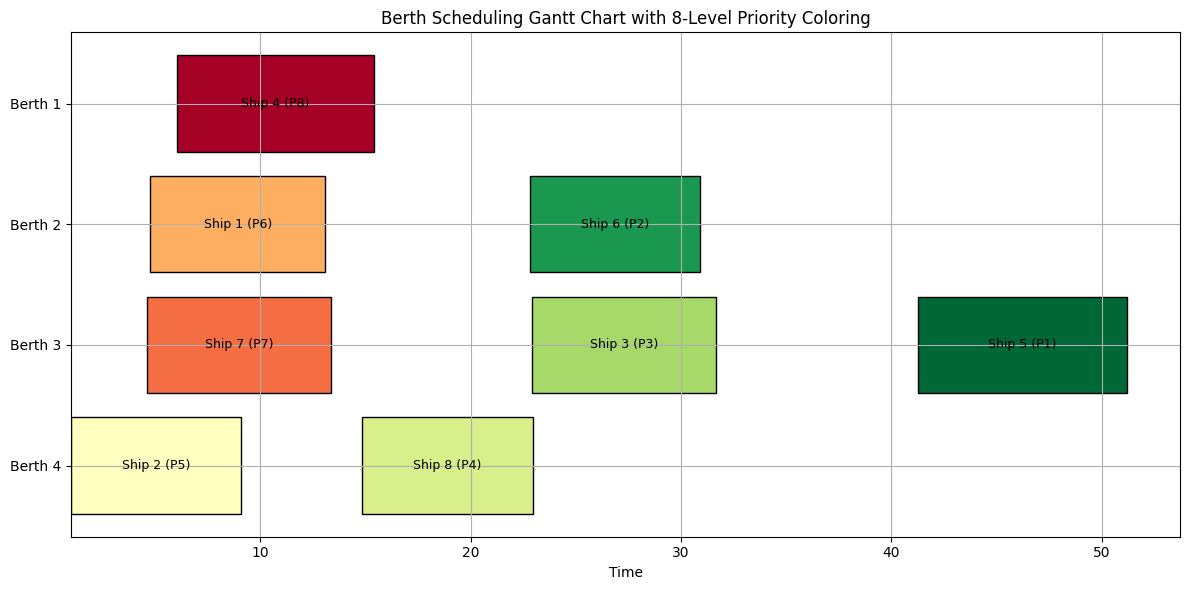

In [ ]:
# (Arrival + Waiting Time)
start_times = {i: value(model_p.A[i]) + value(model_p.W[i]) for i in model_p.Ships}


unload_durations = {}
for (i, j) in model_p.ShipBerths:
    if value(model_p.x[i, j]) > 0.5:
        unload_durations[i] = value(model_p.t[i, j])


assigned_berth = {}
for i in model_p.Ships:
    for j in model_p.Berths:
        if value(model_p.x[i, j]) > 0.5:
            assigned_berth[i] = j



import matplotlib.pyplot as plt
import pandas as pd

df_schedule = pd.DataFrame({
    'Ship': list(start_times.keys()),
    'Start_Time': [start_times[i] for i in start_times],
    'Unload_Duration': [unload_durations[i] for i in start_times],
    'Berth': [assigned_berth[i] for i in start_times],
    'Priority_Value': [value(model_p.p[i]) for i in start_times]
})


df_schedule['Berth'] = df_schedule['Berth'].astype(int)
df_schedule = df_schedule.sort_values(by='Berth', ascending=False)
Berth_labels = sorted(df_schedule['Berth'].unique())
Berth_labels = [f'Berth {d}' for d in Berth_labels]



df_schedule['Priority_Level'] = pd.qcut(df_schedule['Priority_Value'], 8, labels=False) + 1

priority_colors_8 = {
    1: '#006837',
    2: '#1a9850',
    3: '#a6d96a',
    4: '#d9ef8b',
    5: '#ffffbf',
    6: '#fdae61',
    7: '#f46d43',
    8: '#a50026'
}

df_schedule['Color'] = df_schedule['Priority_Level'].map(priority_colors_8)

fig, ax = plt.subplots(figsize=(12, 6))
for _, row in df_schedule.iterrows():
    ax.barh(y=f'Berth {row.Berth}', left=row.Start_Time, width=row.Unload_Duration,
            color=row.Color, edgecolor='black')
    ax.text(row.Start_Time + row.Unload_Duration / 2, f'Berth {row.Berth}',
            f'Ship {row.Ship} (P{row.Priority_Level})', va='center', ha='center', fontsize=9)

ax.set_yticks([f'Berth {d}' for d in sorted(df_schedule['Berth'].unique())])
ax.set_yticklabels(Berth_labels)
ax.set_xlabel("Time")
ax.set_title("Berth Scheduling Gantt Chart with 8-Level Priority Coloring")
plt.grid(True)
plt.tight_layout()
plt.show()


### Berths Capacity Usage

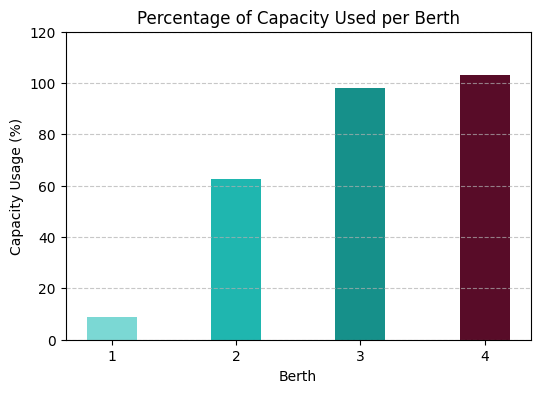

In [ ]:
from pyomo.environ import value

used_capacity = {j: 0 for j in model_p.Berths}

for i in model_p.Ships:
    for j in model_p.Berths:
        if (i, j) in model_p.ShipBerths:
            if value(model_p.x[i, j]) > 0.5:
                used_capacity[j] += value(model_p.c[i])

capacity_usage_percent = {}
for j in model_p.Berths:
    cap = value(model_p.C[j])
    if cap > 0:
        capacity_usage_percent[j] = (used_capacity[j] / cap) * 100
    else:
        capacity_usage_percent[j] = 0  # یا مقدار دلخواه برای ظرفیت صفر

import pandas as pd
import matplotlib.pyplot as plt

df_capacity = pd.DataFrame({
    'Berth': list(capacity_usage_percent.keys()),
    'UsagePercent': list(capacity_usage_percent.values())
})

colors = ['#7bd8d4', '#1fb6af', '#16908a', '#580c28']

plt.figure(figsize=(6, 4))
plt.bar(df_capacity['Berth'].astype(str), df_capacity['UsagePercent'],
        color=colors, width=0.4)
plt.xlabel('Berth')
plt.ylabel('Capacity Usage (%)')
plt.title('Percentage of Capacity Used per Berth')
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Waiting Time

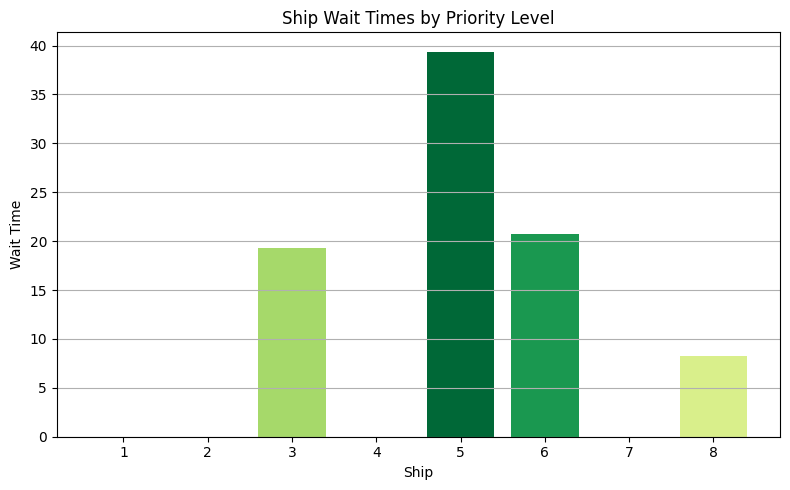

In [ ]:
wait_times = [(i, value(model_p.W[i])) for i in model_p.Ships]
df_W = pd.DataFrame(wait_times, columns=['Ship', 'Wait_Time'])
priority_data = [(i, float(value(model_p.p[i]))) for i in model_p.Ships]
df_priority = pd.DataFrame(priority_data, columns=['Ship', 'Priority_Value'])
df_priority['Priority_Level'] = pd.qcut(df_priority['Priority_Value'], 8, labels=False) + 1
df_W = df_W.merge(df_priority[['Ship', 'Priority_Level']], on='Ship', how='left')
df_W['Color'] = df_W['Priority_Level'].map(priority_colors_8)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(df_W['Ship'].astype(str), df_W['Wait_Time'], color=df_W['Color'])
ax.set_xlabel("Ship")
ax.set_ylabel("Wait Time")
ax.set_title("Ship Wait Times by Priority Level")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 4. Effect of relaxing berth 3 constraint

### Solving the model

In [ ]:
#-----Parameters-----#

import pandas as pd
from pyomo.environ import *

model_d = ConcreteModel(name="berth_scheduling")

# Sets
model_d.Ships = RangeSet(1, 8)
model_d.Berths = RangeSet(1, 4)

# loading excel sheets
c = pd.read_excel('Parameters.xlsx', sheet_name='Containers')
C = pd.read_excel('Parameters.xlsx', sheet_name='Capacity')
l = pd.read_excel('Parameters.xlsx', sheet_name='Length')
L = pd.read_excel('Parameters.xlsx', sheet_name='Max Length')
t = pd.read_excel('Parameters.xlsx', sheet_name='Unload Time')
p = pd.read_excel('Parameters.xlsx', sheet_name='Priority')
C_ec = pd.read_excel('Parameters.xlsx', sheet_name='Cost for Extra Capacity')
E = pd.read_excel('Parameters.xlsx', sheet_name='Max Extra Allowable Capacity')
A = pd.read_excel('Parameters.xlsx', sheet_name='Arrival Time')
epsilon = pd.read_excel('Parameters.xlsx', sheet_name='Lag')
anch = pd.read_excel('Parameters.xlsx', sheet_name='Anchorage')

# fixing tuple in Ship_Berth column
t['Ship_Berth'] = t['Ship_Berth'].apply(eval)
t['Ship_Berth'] = t['Ship_Berth'].apply(lambda x: (int(x[0]), int(x[1])))

# creating dictionaries from DataFrames
c = dict(zip(c['Ship'], c['Containers']))
C = dict(zip(C['Berth'], C['Capacity']))
l = dict(zip(l['Ship'], l['Length']))
L = dict(zip(L['Berth'], L['Max_Length']))
t_dict = dict(zip(t['Ship_Berth'], t['Unload_Time']))
p = dict(zip(p['Ship'], p['Priority']))
C_ec = dict(zip(C_ec['Berth'], C_ec['Cost for Extra Capacity']))
E = dict(zip(E['Berth'], E['Max Extra Allowable Capacity']))
A = dict(zip(A['Ship'], A['Arrival_Time']))
epsilon = dict(zip(epsilon['Berth'], epsilon['Lag']))
anch = dict(zip(anch['Berth'], anch['Anchorage']))

model_d.ShipBerths = Set(dimen=2, initialize=t_dict.keys())

# parameters
model_d.c = Param(model_d.Ships, initialize=c, mutable=True)
model_d.C = Param(model_d.Berths, initialize=C, mutable=True)
model_d.l = Param(model_d.Ships, initialize=l, mutable=True)
model_d.L = Param(model_d.Berths, initialize=L, mutable=True)
model_d.t = Param(model_d.ShipBerths, initialize=t_dict, mutable=True)
model_d.p = Param(model_d.Ships, initialize=p, mutable=True)
model_d.C_ec = Param(model_d.Berths, initialize=C_ec, mutable=True)
model_d.E = Param(model_d.Berths, initialize=E, mutable=True)
model_d.A = Param(model_d.Ships, initialize=A, mutable=True)
model_d.epsilon = Param(model_d.Berths, initialize=epsilon, mutable=True)


#-----Variables-----#

# if ship i assigned to berth j
model_d.x = Var(model_d.Ships, model_d.Berths, domain=Binary)

# if ship i is shipper than k
model_d.Y_index = Set(initialize=[(i, k) for i in model_d.Ships for k in model_d.Ships if i < k])
model_d.y = Var(model_d.Y_index, domain=Binary)

# waiting time of ship i
model_d.W = Var(model_d.Ships, domain=NonNegativeReals)

# used extra capacity
model_d.u = Var(model_d.Berths, domain=NonNegativeReals)

# if W[i] ≥ 10
model_d.delta1 = Var(model_d.Ships, domain=Binary)

# if W[i] ≥ 40
model_d.delta2 = Var(model_d.Ships, domain=Binary)

# if W[i] ≥ 10
model_d.d1 = Var(model_d.Ships, domain=NonNegativeReals)

# if W[i] ≥ 40
model_d.d2 = Var(model_d.Ships, domain=NonNegativeReals)


#-----Objective Function-----#

M = 1e4  # Big-M constant

def objective_rule(model_d):
    # 1. C_unload: sum over ship-berth pairs
    unload_cost = sum(
        5 * model_d.t[i, j] * model_d.x[i, j]
        for (i, j) in model_d.ShipBerths
    )

    # 2. C_EC: sum over berths
    extra_capacity_cost = sum(
        model_d.C_ec[j] * model_d.u[j] for j in model_d.Berths
    )

    # 3. C_W: sum over ships
    waiting_cost = sum(
        25 * model_d.W[i]
        - 15 * model_d.d1[i] + 150 * model_d.delta1[i]
        - 5 * model_d.d2[i] + 200 * model_d.delta2[i]
        for i in model_d.Ships
    )

    return unload_cost + waiting_cost + extra_capacity_cost


model_d.objective = Objective(rule=objective_rule, sense=minimize)


#----- Constraints-----#

# each ship is assigned to exactly one berth
def assign_one_berth(model_d, i):
    return sum(model_d.x[i, j] for j in model_d.Berths if (i, j) in model_d.ShipBerths) == 1
model_d.one_berth_per_ship = Constraint(model_d.Ships, rule=assign_one_berth)

# number of ships assigned to berths
def max_two_ships_per_berth_1_and_2_and_4(model_d, j):
    if j in [1, 2, 4]:
        return sum(model_d.x[i, j] for i in model_d.Ships if (i, j) in model_d.ShipBerths) <= 2
    else:
        return Constraint.Skip
model_d.max_ships_berth = Constraint(model_d.Berths, rule=max_two_ships_per_berth_1_and_2_and_4)

def exactly_three_ships_berth_3(model_d):
    return sum(model_d.x[i, 3] for i in model_d.Ships if (i, 3) in model_d.ShipBerths) <= 3
model_d.exact_three_ships_berth3 = Constraint(rule=exactly_three_ships_berth_3)

# length constraint
def length_constraint(model_d, i, j):
    return model_d.l[i] * model_d.x[i, j] <= model_d.L[j]
model_d.length_constraint = Constraint(model_d.Ships, model_d.Berths, rule=length_constraint)

# berths capacity
def berth_capacity_constraint(model_d, j):
    return sum(model_d.c[i] * model_d.x[i, j] for i in model_d.Ships if (i, j) in model_d.ShipBerths) <= model_d.C[j] + model_d.u[j]
model_d.capacity_constraint = Constraint(model_d.Berths, rule=berth_capacity_constraint)

# each berth extra capacity
def each_berth_capacity_constraint(model_d, j):
    return model_d.u[j] <= model_d.E[j]
model_d.berth_capacity_constraint = Constraint(model_d.Berths, rule=each_berth_capacity_constraint)

# Constraint: p[k] - p[i] <= y[i,k]
def priority_1(model_d, i, k):
    return model_d.p[i] - model_d.p[k] <= model_d.y[i, k]
model_d.priority_con_1 = Constraint(model_d.Y_index, rule=priority_1)

# Constraint: p[k] - p[i] <= 1 - y[i,k]
def priority_2(model_d, i, k):
    return model_d.p[k] - model_d.p[i] <= 1 - model_d.y[i, k]
model_d.priority_con_2 = Constraint(model_d.Y_index, rule=priority_2)

# SEQUENCING 1
def sequencing_constraint_1(model_d, i, k, j):
    if i < k:
        return (
            model_d.W[k] + model_d.A[k] >=
            model_d.W[i] + model_d.A[i] + model_d.t[i, j] + model_d.epsilon[j]
            - M * (3 - model_d.y[i, k] - model_d.x[i, j] - model_d.x[k, j])
        )
    else:
        return Constraint.Skip
model_d.Sequencing1 = Constraint(model_d.Ships, model_d.Ships, model_d.Berths, rule=sequencing_constraint_1)

# SEQUENCING 2
def sequencing_constraint_2(model_d, i, k, j):
    if i < k:
        return (
            model_d.W[i] + model_d.A[i] >=
            model_d.W[k] + model_d.A[k] + model_d.t[k, j] + model_d.epsilon[j]
            - M * (model_d.y[i, k] + 2 - model_d.x[i, j] - model_d.x[k, j])
        )
    else:
        return Constraint.Skip
model_d.Sequencing2 = Constraint(model_d.Ships, model_d.Ships, model_d.Berths, rule=sequencing_constraint_2)

# W[i] <= 80 * [1 - p[i]]
def waiting_upper(model_d, i):
    return model_d.W[i] <= 80 * (1 - model_d.p[i])
model_d.waiting_upper_con = Constraint(model_d.Ships, rule=waiting_upper)

# Constraint: W[i] - 10 <= M delta1[i]
def delta1_conditional_lower(model_d, i):
    return model_d.W[i] - 10 <= M * model_d.delta1[i]
model_d.delta1_lower_con = Constraint(model_d.Ships, rule=delta1_conditional_lower)

# Constraint: W[i] - 40 <= M delta2[i]
def delta2_conditional_lower(model_d, i):
    return model_d.W[i] - 40 <= M * model_d.delta2[i]
model_d.delta2_lower_con = Constraint(model_d.Ships, rule=delta2_conditional_lower)

# Constraint: d1[i] <= W[i]
def d1_conditional_upper1(model_d, i):
    return model_d.d1[i] <= model_d.W[i]
model_d.d1_conditional_con1 = Constraint(model_d.Ships, rule=d1_conditional_upper1)

# Constraint: d2[i] <= W[i]
def d2_conditional_upper1(model_d, i):
    return model_d.d2[i] <= model_d.W[i]
model_d.d2_conditional_con1 = Constraint(model_d.Ships, rule=d2_conditional_upper1)

# Constraint: d1[i] <= M * delta1[i]
def d1_conditional_upper2(model_d, i):
    return model_d.d1[i] <= M * model_d.delta1[i]
model_d.d1_conditional_con2 = Constraint(model_d.Ships, rule=d1_conditional_upper2)

# Constraint: d2[i] <= M * delta2[i]
def d2_conditional_upper2(model_d, i):
    return model_d.d2[i] <= M * model_d.delta2[i]
model_d.d2_conditional_con2 = Constraint(model_d.Ships, rule=d2_conditional_upper2)


#-----Solving-----#

from pyomo.opt import SolverStatus, TerminationCondition

solver = SolverFactory('glpk')
results = solver.solve(model_d, tee=True)

print("Optimal objective value:", value(model_d.objective))

from pyomo.environ import value

for i in model_d.Ships:
    assigned_berth = next((j for j in model_d.Berths if value(model_d.x[i, j]) > 0.5), None)
    print(f"Ship {i}: Assigned to Berth {assigned_berth}")


unload_cost_value = sum(
    5 * model_d.t[i, j] * model_d.x[i, j].value
    for (i, j) in model_d.ShipBerths
)

extra_capacity_cost_value = sum(
    model_d.C_ec[j] * model_d.u[j].value
    for j in model_d.Berths
)

waiting_cost_value = sum(
    25 * model_d.W[i].value
    - 15 * model_d.d1[i].value + 150 * model_d.delta1[i].value
    - 5 * model_d.d2[i].value + 200 * model_d.delta2[i].value
    for i in model_d.Ships
)

print(f"Unload cost: {unload_cost_value}")
print(f"Extra capacity cost: {extra_capacity_cost_value}")
print(f"Waiting cost: {waiting_cost_value}")
print(f"Total cost: {unload_cost_value + extra_capacity_cost_value + waiting_cost_value}")

print("Waiting time (W[i]) for each ship:")
for i in model_d.Ships:
    print(f"Ship {i}: {model_d.W[i].value:.2f} time units")



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpdfosryh0.glpk.raw --wglp /tmp/tmp10amy8ok.glpk.glp --cpxlp
 /tmp/tmppahtozrj.pyomo.lp
Reading problem data from '/tmp/tmppahtozrj.pyomo.lp'...
/tmp/tmppahtozrj.pyomo.lp:2770: warning: lower bound of variable 'x2' redefined
/tmp/tmppahtozrj.pyomo.lp:2770: warning: upper bound of variable 'x2' redefined
388 rows, 104 columns, 1416 non-zeros
76 integer variables, all of which are binary
2846 lines were read
Writing problem data to '/tmp/tmp10amy8ok.glpk.glp'...
2403 lines were written
GLPK Integer Optimizer 5.0
388 rows, 104 columns, 1416 non-zeros
76 integer variables, all of which are binary
Preprocessing...
172 constraint coefficient(s) were reduced
128 rows, 68 columns, 444 non-zeros
41 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  7.017e+01  ratio =  7.017e+01
GM: min|aij| =  5.962e-01  max|aij| =  1.677e+00  ratio =  2.814e+00
EQ: min|aij| =  3.7

In [ ]:
print(f"Original Objective: {value(model_p.objective)}, New Objective: {value(model_d.objective)}")

Original Objective: 1803.2706014701057, New Objective: 1605.5574635658427


### visualization new model

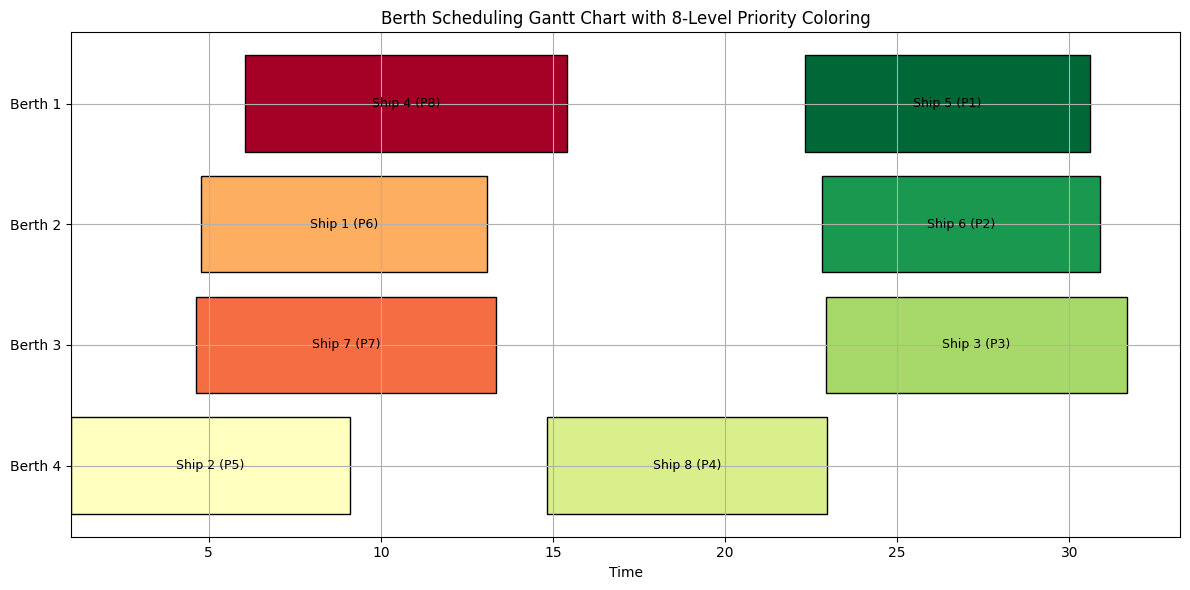

In [ ]:
start_times = {i: value(model_d.A[i]) + value(model_d.W[i]) for i in model_d.Ships}

unload_durations = {}
for (i, j) in model_d.ShipBerths:
    if value(model_d.x[i, j]) > 0.5:
        unload_durations[i] = value(model_d.t[i, j])

assigned_berth = {}
for i in model_d.Ships:
    for j in model_d.Berths:
        if value(model_d.x[i, j]) > 0.5:
            assigned_berth[i] = j



import matplotlib.pyplot as plt
import pandas as pd

df_schedule = pd.DataFrame({
    'Ship': list(start_times.keys()),
    'Start_Time': [start_times[i] for i in start_times],
    'Unload_Duration': [unload_durations[i] for i in start_times],
    'Berth': [assigned_berth[i] for i in start_times],
    'Priority_Value': [value(model_p.p[i]) for i in start_times]
})

df_schedule['Berth'] = df_schedule['Berth'].astype(int)
df_schedule = df_schedule.sort_values(by='Berth', ascending=False)
Berth_labels = sorted(df_schedule['Berth'].unique())
Berth_labels = [f'Berth {d}' for d in Berth_labels]



df_schedule['Priority_Level'] = pd.qcut(df_schedule['Priority_Value'], 8, labels=False) + 1

priority_colors_8 = {
    1: '#006837',
    2: '#1a9850',
    3: '#a6d96a',
    4: '#d9ef8b',
    5: '#ffffbf',
    6: '#fdae61',
    7: '#f46d43',
    8: '#a50026'
}

df_schedule['Color'] = df_schedule['Priority_Level'].map(priority_colors_8)

fig, ax = plt.subplots(figsize=(12, 6))
for _, row in df_schedule.iterrows():
    ax.barh(y=f'Berth {row.Berth}', left=row.Start_Time, width=row.Unload_Duration,
            color=row.Color, edgecolor='black')
    ax.text(row.Start_Time + row.Unload_Duration / 2, f'Berth {row.Berth}',
            f'Ship {row.Ship} (P{row.Priority_Level})', va='center', ha='center', fontsize=9)

ax.set_yticks([f'Berth {d}' for d in sorted(df_schedule['Berth'].unique())])
ax.set_yticklabels(Berth_labels)
ax.set_xlabel("Time")
ax.set_title("Berth Scheduling Gantt Chart with 8-Level Priority Coloring")
plt.grid(True)
plt.tight_layout()
plt.show()


### waiting time diffrences

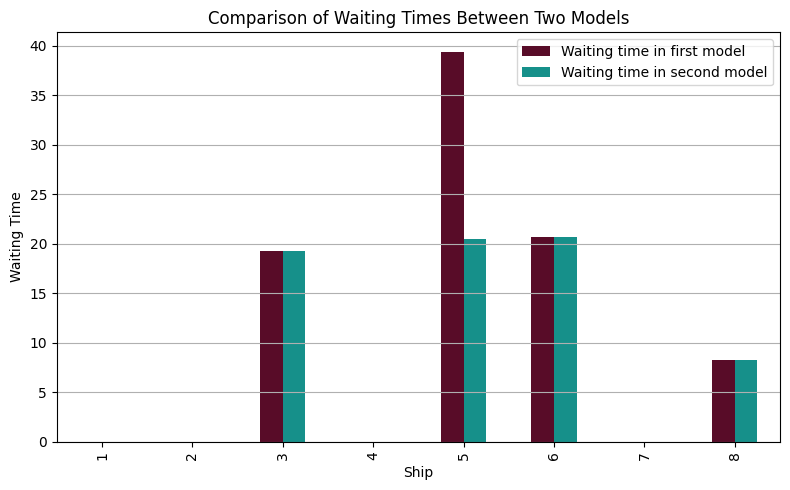

In [ ]:
waiting_p = {i: value(model_p.W[i]) for i in model_p.Ships}
waiting_d = {i: value(model_d.W[i]) for i in model_d.Ships}

df_wait_compare = pd.DataFrame({
    'Ship': list(waiting_p.keys()),
    'Waiting time in first model': [waiting_p[i] for i in waiting_p],
    'Waiting time in second model': [waiting_d[i] for i in waiting_d],
})
df_wait_compare['Diff'] = df_wait_compare['Waiting time in second model'] - df_wait_compare['Waiting time in first model']

df_wait_compare.plot(
    x='Ship',
    y=['Waiting time in first model', 'Waiting time in second model'],
    kind='bar',
    figsize=(8, 5),
    color=['#580c28','#16908a'],
)
plt.title("Comparison of Waiting Times Between Two Models")
plt.ylabel("Waiting Time")
plt.xlabel("Ship")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 6. Pyomo Sensitivity Analysis

### Lag time of Berth 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from tabulate import tabulate

# Define range for epsilon[2] (lag at Berth 2)
epsilon_values = np.arange(5, 10.5, 0.5)

results = []

for eps in epsilon_values:
    # Update lag time
    model_p.epsilon[2] = eps

    # Solve the model
    solver = SolverFactory('glpk')
    result = solver.solve(model_p, tee=False)

    if (result.solver.status == SolverStatus.ok) and \
       (result.solver.termination_condition == TerminationCondition.optimal):

        obj_val = round(value(model_p.objective), 2)
        waiting_times = {f'W_{i}': round(value(model_p.W[i]), 2) for i in model_p.Ships}
        assignments = {
            f'Ship_{i}_Assigned_Berth': j
            for i in model_p.Ships
            for j in model_p.Berths
            if (i, j) in model_p.ShipBerths and value(model_p.x[i, j]) > 0.5
        }

        row = {
            'Epsilon_Berth_2': eps,
            'Objective': obj_val,
            **waiting_times,
            **assignments
        }
        results.append(row)

    else:
        print(f"epsilon[2] = {eps} → No optimal solution.")
        results.append({
            'Epsilon_Berth_2': eps,
            'Objective': None
        })

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Drop rows with no objective (infeasible)
df_plot = df_results.dropna(subset=['Objective'])

# Show full table
print("\nSensitivity Analysis Results:")
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))




Best Scenario:
  - Epsilon[2] = 5.0 minutes
  - Minimum Objective = 1755.99


Sensitivity Analysis Results:
╒═══════════════════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╕
│   Epsilon_Berth_2 │   Objective │   W_1 │   W_2 │   W_3 │   W_4 │   W_5 │   W_6 │   W_7 │   W_8 │   Ship_1_Assigned_Berth │   Ship_2_Assigned_Berth │   Ship_3_Assigned_Berth │   Ship_4_Assigned_Berth │   Ship_5_Assigned_Berth │   Ship_6_Assigned_Berth │   Ship_7_Assigned_Berth │   Ship_8_Assigned_Berth │
╞═══════════════════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪════════════════════

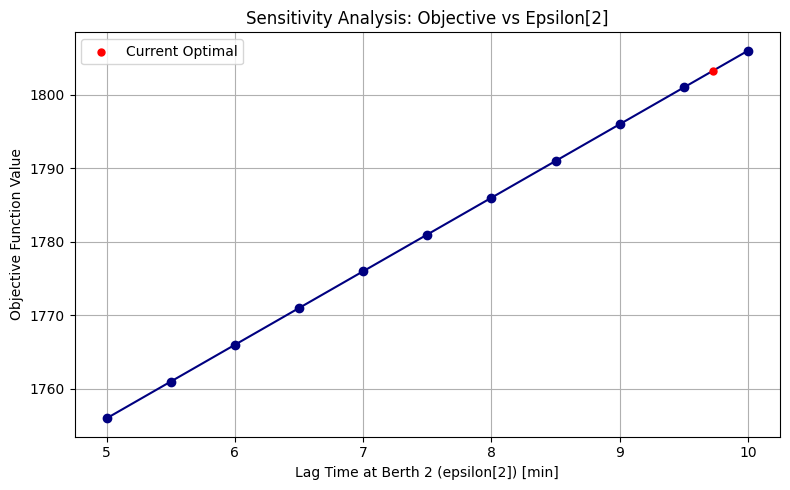

In [ ]:
highlight_x = 9.72782535009737
highlight_y = 1803.2706014701057

plt.figure(figsize=(8, 5))
plt.plot(df_plot['Epsilon_Berth_2'], df_plot['Objective'], marker='o', color='navy')


plt.scatter(highlight_x, highlight_y, color='red', s=25, label='Current Optimal', zorder=5)

plt.title('Sensitivity Analysis: Objective vs Epsilon[2]')
plt.xlabel('Lag Time at Berth 2 (epsilon[2]) [min]')
plt.ylabel('Objective Function Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Unloading Ship 7 on berth 3

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory
from tabulate import tabulate

# Define range for unloading time of ship 7 at berth 3
unload_times = np.arange(5,20,0.5)

results = []

for unload_time in unload_times:
    # Update unloading time for ship 7 at berth 3
    model_p.t[7, 3] = unload_time

    # Solve model
    solver = SolverFactory('glpk')
    result = solver.solve(model_p, tee=False)

    # Get objective function value
    obj_val = value(model_p.objective)

    # Extract waiting time for each ship
    waiting_times = {f'W_{i}': round(value(model_p.W[i]), 2) for i in model_p.Ships}

    # Extract assignments (ship i assigned to berth j)
    assignments = {
        f'Ship_{i}_Assigned_Berth': j
        for i in model_p.Ships
        for j in model_p.Berths
        if (i, j) in model_p.ShipBerths and value(model_p.x[i, j]) > 0.5
    }

    # Store results for this unload_time
    row = {
        'Unload_Time_Ship7_Berth3': unload_time,
        'Objective': round(obj_val, 2),
        **waiting_times,
        **assignments
    }
    results.append(row)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Find best scenario (minimum objective)
best_row = df_results.loc[df_results['Objective'].idxmin()]

# Print full results table
print("Sensitivity Analysis Results:")
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))

 Best Scenario:
   - Unloading time of Ship 7 at Berth 3 = 5.0 minutes
   - Minimum Objective Value = 1712.69

Sensitivity Analysis Results:
╒════════════════════════════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╕
│   Unload_Time_Ship7_Berth3 │   Objective │   W_1 │   W_2 │   W_3 │   W_4 │   W_5 │   W_6 │   W_7 │   W_8 │   Ship_1_Assigned_Berth │   Ship_2_Assigned_Berth │   Ship_3_Assigned_Berth │   Ship_4_Assigned_Berth │   Ship_5_Assigned_Berth │   Ship_6_Assigned_Berth │   Ship_7_Assigned_Berth │   Ship_8_Assigned_Berth │
╞════════════════════════════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════

Interpolated X for Objective = 1803.2706 is: 8.6232


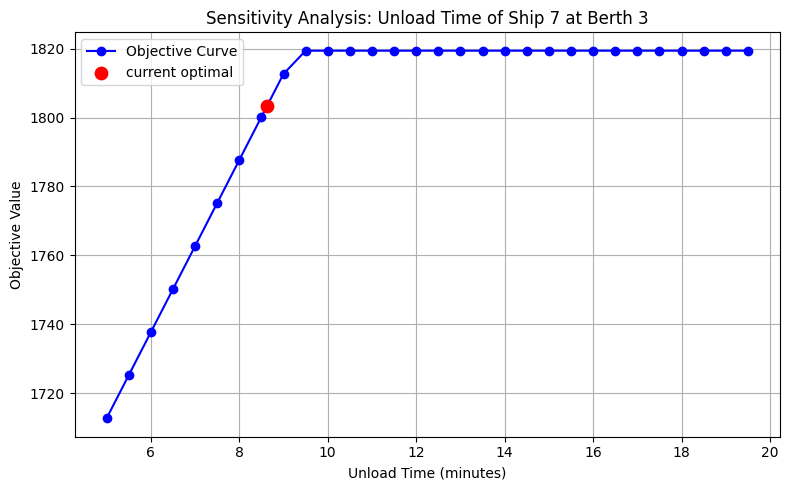

In [ ]:
# Plot objective vs unloading time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Get x and y values
x_vals = df_results['Unload_Time_Ship7_Berth3'].values
y_vals = df_results['Objective'].values

# Sort data by y for interpolation
sorted_indices = np.argsort(y_vals)
x_sorted = x_vals[sorted_indices]
y_sorted = y_vals[sorted_indices]

# Create interpolation function: y -> x (inverse mapping)
f_inv = interp1d(y_sorted, x_sorted, fill_value="extrapolate", assume_sorted=True)

# Define the target objective
target_y = 1803.2706014701057

# Interpolate x for the target y
x_at_target_y = f_inv(target_y)

print(f"Interpolated X for Objective = {target_y:.4f} is: {x_at_target_y:.4f}")

# Plot the original data
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, marker='o', color='blue', label='Objective Curve')

# Plot the interpolated point
plt.scatter(x_at_target_y, target_y, color='red', s=80, label='current optimal', zorder=5)

plt.title('Sensitivity Analysis: Unload Time of Ship 7 at Berth 3')
plt.xlabel('Unload Time (minutes)')
plt.ylabel('Objective Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()





### Capacity of Berth 2

In [ ]:
import numpy as np
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
from tabulate import tabulate

solver = SolverFactory('glpk')

# Save the initial capacity of berth 2
initial_capacity_2 = model_p.C[2].value  # Use .value to get numeric

# Define capacity values for berth 2 from 5 to 40 with step 1
capacity_values = np.arange(5, 41, 1)

results = []

for cap in capacity_values:
    # Update the capacity of berth 2 correctly using .value
    model_p.C[2].value = cap

    # Solve the model and print solver output for debugging
    result = solver.solve(model_p, tee=False)
    if (result.solver.status != SolverStatus.ok) or (result.solver.termination_condition != TerminationCondition.optimal):
        print(f"Warning: Solver did not find optimal solution for capacity {cap}")

    # Get the objective function value
    obj_val = value(model_p.objective)

    # Extract waiting time for each ship, rounded to 2 decimals
    waiting_times = {f'W_{i}': round(value(model_p.W[i]), 2) for i in model_p.Ships}

    # Extract ship assignments to berths
    assignments = {
        f'Ship_{i}_Assigned_Berth': j
        for i in model_p.Ships
        for j in model_p.Berths
        if (i, j) in model_p.ShipBerths and value(model_p.x[i, j]) > 0.5
    }

    # Prepare a row for the results DataFrame
    row = {
        'Capacity_Berth2': cap,
        'Objective': round(obj_val, 2),
        **waiting_times,
        **assignments
    }

    results.append(row)

# Restore the initial capacity of berth 2 after sensitivity analysis
model_p.C[2].value = initial_capacity_2

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Find the best scenario (minimum objective value)
best_row = df_results.loc[df_results['Objective'].idxmin()]

print("Sensitivity Analysis Results:")
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))


 Best Scenario:
   - Capacity of Berth 2 = 25.0
   - Minimum Objective Value = 1803.27

Sensitivity Analysis Results:
╒═══════════════════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╕
│   Capacity_Berth2 │   Objective │   W_1 │   W_2 │   W_3 │   W_4 │   W_5 │   W_6 │   W_7 │   W_8 │   Ship_1_Assigned_Berth │   Ship_2_Assigned_Berth │   Ship_3_Assigned_Berth │   Ship_4_Assigned_Berth │   Ship_5_Assigned_Berth │   Ship_6_Assigned_Berth │   Ship_7_Assigned_Berth │   Ship_8_Assigned_Berth │
╞═══════════════════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═══════════

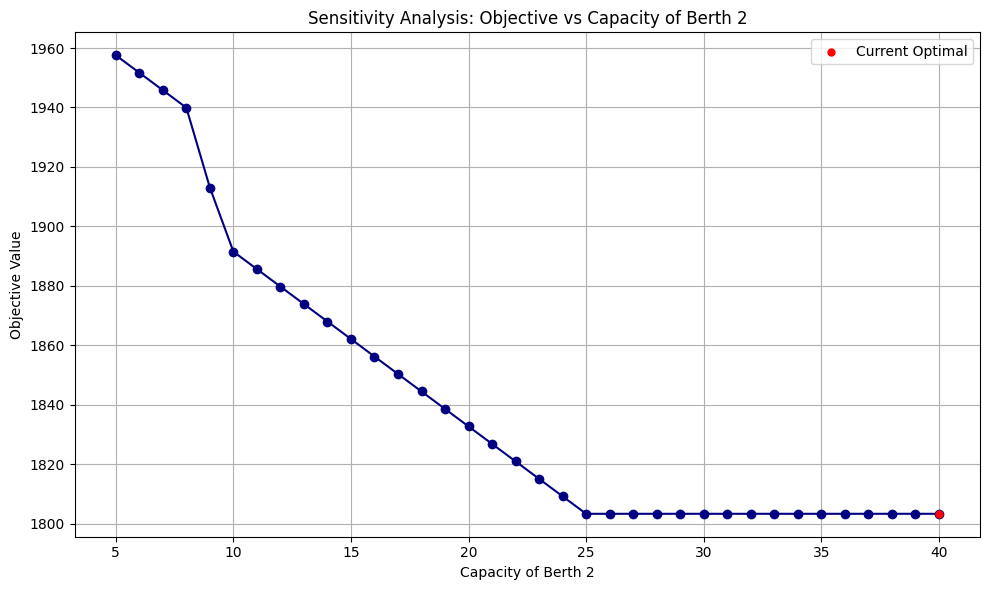

In [ ]:
import matplotlib.pyplot as plt

highlight_x = 40
highlight_y = 1803.2706014701057

plt.figure(figsize=(10,6))
plt.plot(df_results['Capacity_Berth2'], df_results['Objective'], marker='o', color='navy')

plt.scatter(highlight_x, highlight_y, color='red', s=25, label='Current Optimal', zorder=5)

plt.title('Sensitivity Analysis: Objective vs Capacity of Berth 2')
plt.xlabel('Capacity of Berth 2')
plt.ylabel('Objective Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




### Capacity of Berth 3

In [ ]:
import numpy as np
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
from tabulate import tabulate

# Ensure model and its components are already defined (e.g., model_p, model_p.C, etc.)

# Make sure the parameter is mutable
assert model_p.C.mutable == True, "Parameter C must be defined as mutable in the model."

solver = SolverFactory('glpk')

# Save the original capacity value of berth 3
original_capacity_3 = model_p.C[3].value

# Define capacity values from 5 to 60 (inclusive)
capacity_values = list(np.arange(5, 61, 1))

# Include the original capacity if it's not already in the list
if original_capacity_3 not in capacity_values:
    capacity_values.insert(0, original_capacity_3)

results = []

# Loop through each capacity value
for cap in capacity_values:
    model_p.C[3] = cap  # Update capacity for berth 3

    # Solve the model
    result = solver.solve(model_p, tee=False)

    # Only collect results if the solution is optimal
    if (result.solver.status == SolverStatus.ok) and (result.solver.termination_condition == TerminationCondition.optimal):
        obj_val = round(value(model_p.objective), 2)

        # Extract waiting times
        waiting_times = {f'W_{i}': round(value(model_p.W[i]), 2) for i in model_p.Ships}

        # Extract ship-berth assignments
        assignments = {
            f'Ship_{i}_Assigned_Berth': j
            for i in model_p.Ships
            for j in model_p.Berths
            if (i, j) in model_p.ShipBerths and value(model_p.x[i, j]) > 0.5
        }

        # Record all results
        row = {
            'Capacity_Berth3': cap,
            'Objective': obj_val,
            **waiting_times,
            **assignments
        }
        results.append(row)
    else:
        print(f"⚠️ Solver failed or returned non-optimal result for capacity {cap}, skipping...")

# Restore the original capacity
model_p.C[3] = original_capacity_3

# Create a DataFrame from results
df_results = pd.DataFrame(results)

# Find and display the best scenario (minimum objective)
best_row = df_results.loc[df_results['Objective'].idxmin()]

print("\n✅ Best Scenario for Berth 3:")
print(f"   - Capacity = {best_row['Capacity_Berth3']}")
print(f"   - Objective = {best_row['Objective']}\n")

# Print full results as a table
print("📊 Full Sensitivity Analysis Results:")
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))



✅ Best Scenario for Berth 3:
   - Capacity = 51.0
   - Objective = 1803.27

📊 Full Sensitivity Analysis Results:
╒═══════════════════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╕
│   Capacity_Berth3 │   Objective │   W_1 │   W_2 │   W_3 │   W_4 │   W_5 │   W_6 │   W_7 │   W_8 │   Ship_1_Assigned_Berth │   Ship_2_Assigned_Berth │   Ship_3_Assigned_Berth │   Ship_4_Assigned_Berth │   Ship_5_Assigned_Berth │   Ship_6_Assigned_Berth │   Ship_7_Assigned_Berth │   Ship_8_Assigned_Berth │
╞═══════════════════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═══════════════

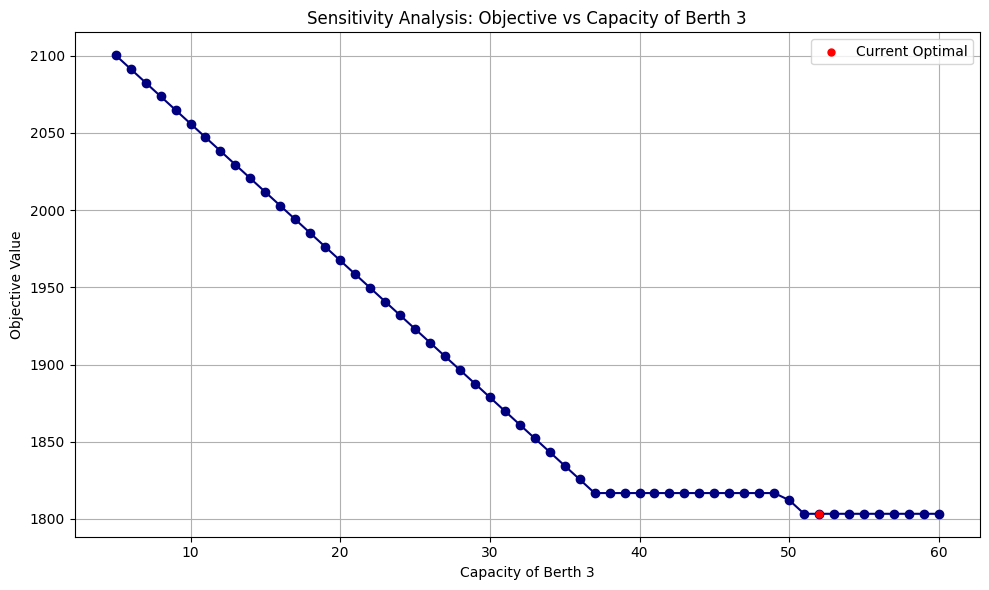

In [ ]:
import matplotlib.pyplot as plt

highlight_x = 52
highlight_y = 1803.2706014701057

plt.figure(figsize=(10,6))
plt.plot(df_results['Capacity_Berth3'], df_results['Objective'], marker='o', color='navy')

plt.scatter(highlight_x, highlight_y, color='red', s=25, label='Current Optimal', zorder=5)

plt.title('Sensitivity Analysis: Objective vs Capacity of Berth 3')
plt.xlabel('Capacity of Berth 3')
plt.ylabel('Objective Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Arrival Time of Ship 6

In [ ]:
import numpy as np
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
from tabulate import tabulate

solver = SolverFactory('glpk')

# Save original arrival time of ship 6
original_arrival_6 = model_p.A[6].value

# Generate arrival times from 1 to 5 with step 0.1
arrival_times = np.round(np.arange(1, 5.1, 0.1), 2)

results = []

for arrival in arrival_times:
    model_p.A[6] = arrival  # Update arrival time of ship 6

    result = solver.solve(model_p, tee=False)

    if result.solver.termination_condition != TerminationCondition.optimal:
        print(f"Solver warning at arrival time {arrival}")
        continue

    obj_val = value(model_p.objective)

    waiting_times = {f'W_{i}': round(value(model_p.W[i]), 2) for i in model_p.Ships}

    assignments = {
        f'Ship_{i}_Assigned_Berth': j
        for i in model_p.Ships
        for j in model_p.Berths
        if (i, j) in model_p.ShipBerths and value(model_p.x[i, j]) > 0.5
    }

    row = {
        'Arrival_6': arrival,
        'Objective': round(obj_val, 2),
        **waiting_times,
        **assignments
    }

    results.append(row)

# Restore original arrival time
model_p.A[6] = original_arrival_6

# DataFrame
df_results = pd.DataFrame(results)



print("📊 Sensitivity Analysis Results for Ship 6 Arrival:")
print(tabulate(df_results, headers='keys', tablefmt='fancy_grid', showindex=False))


📊 Sensitivity Analysis Results for Ship 6 Arrival:
╒═════════════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╕
│   Arrival_6 │   Objective │   W_1 │   W_2 │   W_3 │   W_4 │   W_5 │   W_6 │   W_7 │   W_8 │   Ship_1_Assigned_Berth │   Ship_2_Assigned_Berth │   Ship_3_Assigned_Berth │   Ship_4_Assigned_Berth │   Ship_5_Assigned_Berth │   Ship_6_Assigned_Berth │   Ship_7_Assigned_Berth │   Ship_8_Assigned_Berth │
╞═════════════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╡
│         1   │     1814.45 │     0 │     0

Interpolated X for Objective = 1803.2706 is: 2.1179


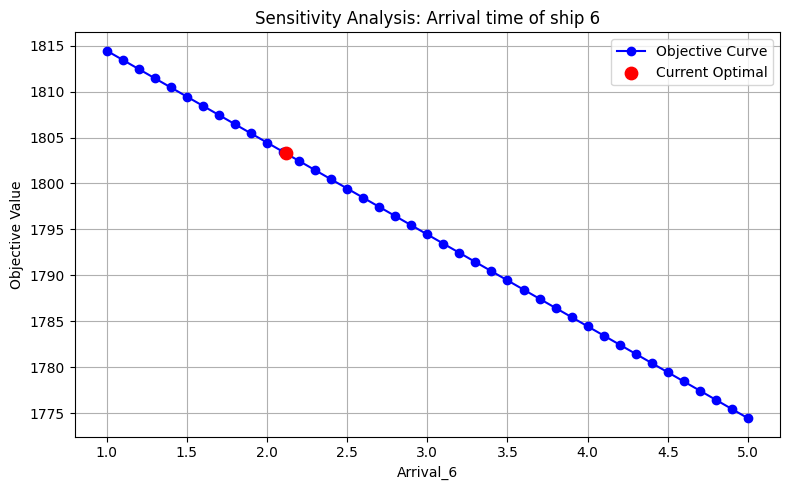

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Get x and y values from the DataFrame
x_vals = df_results['Arrival_6'].values
y_vals = df_results['Objective'].values

# Sort data by objective value for interpolation
sorted_indices = np.argsort(y_vals)
x_sorted = x_vals[sorted_indices]
y_sorted = y_vals[sorted_indices]

# Create inverse interpolation function (y -> x)
f_inv = interp1d(y_sorted, x_sorted, fill_value="extrapolate", assume_sorted=True)

# Target objective value
target_y = 1803.2706014701057

# Interpolate x value corresponding to target objective
x_at_target_y = f_inv(target_y)

print(f"Interpolated X for Objective = {target_y:.4f} is: {x_at_target_y:.4f}")

# Plot the original data and highlight the interpolated point
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, marker='o', color='blue', label='Objective Curve')
plt.scatter(x_at_target_y, target_y, color='red', s=80, label='Current Optimal', zorder=5)
plt.title('Sensitivity Analysis: Arrival time of ship 6')
plt.xlabel('Arrival_6')
plt.ylabel('Objective Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
